In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

def DDTW ↓

In [2]:
def DDTW(Q, C):
    """
    Args:
        Q (np.array or list): 一つ目の波形
        C (np.array or list): 二つ目の波形

    Returns:
        γ_mat (np.array): DDTWを計算するための行列
        arrows (np.array): 各時点で←・↙︎・↓のどのマスが最小だったかを示す記号を保存する行列
        ddtw (float): DDTW
    """
    Q, C = np.array(Q), np.array(C)
    assert Q.shape[0] > 3, "一つ目の波形のフォーマットがおかしいです。"
    assert C.shape[0] > 3, "二つ目の波形のフォーマットがおかしいです。"

    # 3.1 Algorithm details の式
    def _Dq(q):
        return ((q[1] - q[0]) + (q[2] - q[0]) / 2) / 2

    # 二つの時点間の距離
    def _γ(x, y):
        return abs(_Dq(x) - _Dq(y))

    # 各変数
    n, m = Q.shape[0] - 2, C.shape[0] - 2
    γ_mat = np.zeros((n, m))
    arrows = np.array(np.zeros((n, m)), dtype=str)  # 可視化用の行列でDDTWの値とは無関係

    # 一番左下のスタート地点
    γ_mat[0, 0] = _γ(Q[0:3], C[0:3])

    # 一列目を計算
    for i in range(1, n):
        γ_mat[i, 0] = γ_mat[i - 1, 0] + _γ(Q[i - 1 : i + 2], C[0:3])
        arrows[i, 0] = "↓"

    # 一行目を計算
    for j in range(1, m):
        γ_mat[0, j] = γ_mat[0, j - 1] + _γ(Q[0:3], C[j - 1 : j + 2])
        arrows[0, j] = "←"

    # 残りのマスを計算
    for i in range(1, n):
        for j in range(1, m):
            # DDTWを求めるためのマトリクスを埋める
            d_ij = _γ(Q[i - 1 : i + 2], C[j - 1 : j + 2])
            γ_mat[i, j] = d_ij + np.min(
                [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
            )

            # 矢印を書くための行列(DDTWの値とは関係無い処理)
            if (
                square_index := np.argmin(
                    [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
                )
            ) == 0:
                arrows[i, j] = "↙︎"
            elif square_index == 1:
                arrows[i, j] = "↓"
            elif square_index == 2:
                arrows[i, j] = "←"

    return γ_mat, arrows, γ_mat[n - 1, m - 1]

In [3]:
df = pd.read_csv("../datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()

0.5618811881188119


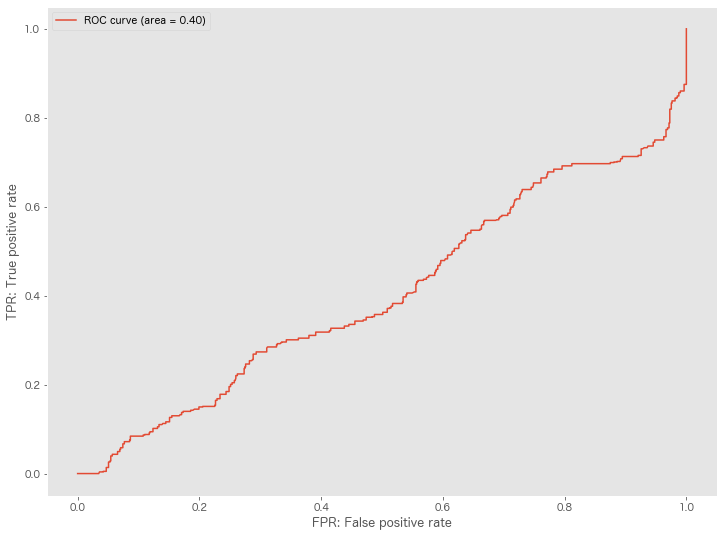

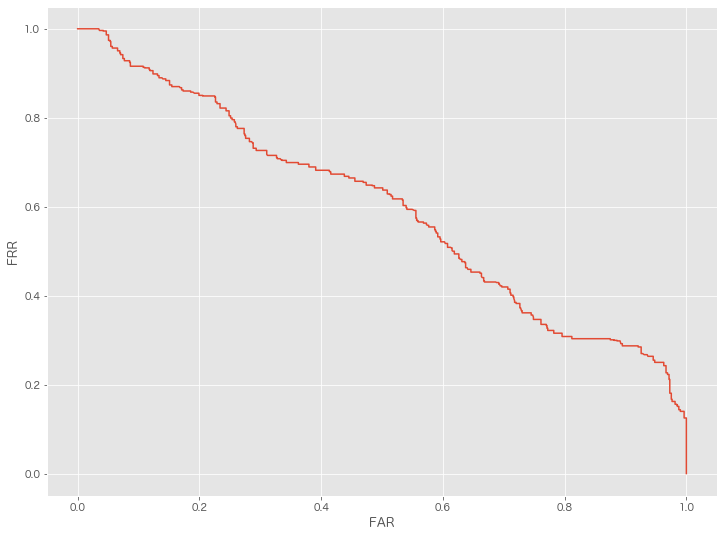

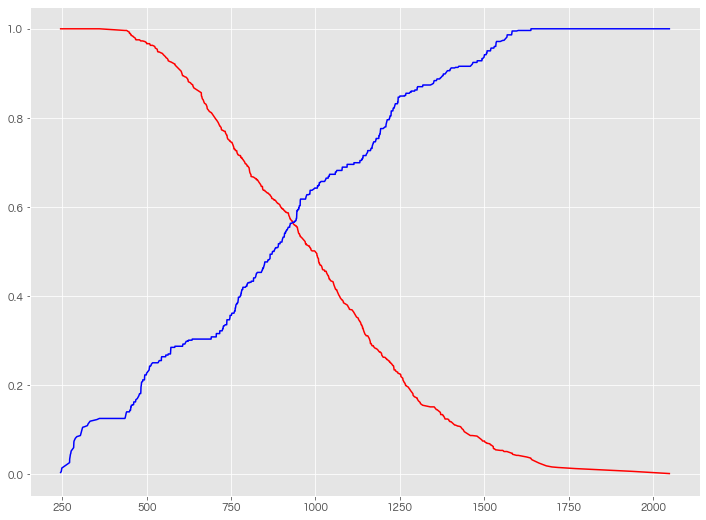

In [6]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []

diff_day_1 = 30
diff_day_2 = 30

data = df

for h in range(len(users)):
    user = users[h]
    for i in range(0, 101):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=diff_day_1)
        imposters = users.copy()
        imposters = imposters[~(imposters == user)]
        imposter = np.random.choice(imposters)

        t_Q = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )

        t_T = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                & (data["date"] < (first_date[0]))
            ]["battery"].copy()
        )

        i_Q = pd.DataFrame(
            data.loc[
                (data["User"] == imposter)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )

        a, b, ddtw_1 = DDTW(t_T, t_Q)
        score_G.append(ddtw_1)

        a, b, ddtw_2 = DDTW(t_T, i_Q)
        score_I.append(ddtw_2)

grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
score = np.concatenate((score_G, score_I))
far, tpr, threshold = metrics.roc_curve(grand_truth, score)
auc = metrics.auc(far, tpr)
frr = 1.0 - tpr
eer = far[np.where((far - frr) < 0)[0][-1]]
print(eer)


plt.plot(far, tpr, label="ROC curve (area = %.2f)" % auc)
plt.legend()
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.show()

plt.plot(far, frr)
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.show()

far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])
plt.plot(far_kai, color="r")
plt.plot(frr_kai, color="b")
plt.show()
# print((first_date[0] + dt.timedelta(seconds=1)), last_date[0])
# print(first_date[0] - dt.timedelta(days=diff_day_2), first_date[0])
# print(len(t_Q), len(t_T))
# print(ddtw)
# EER:0.5618811881188119

0.5952970297029703


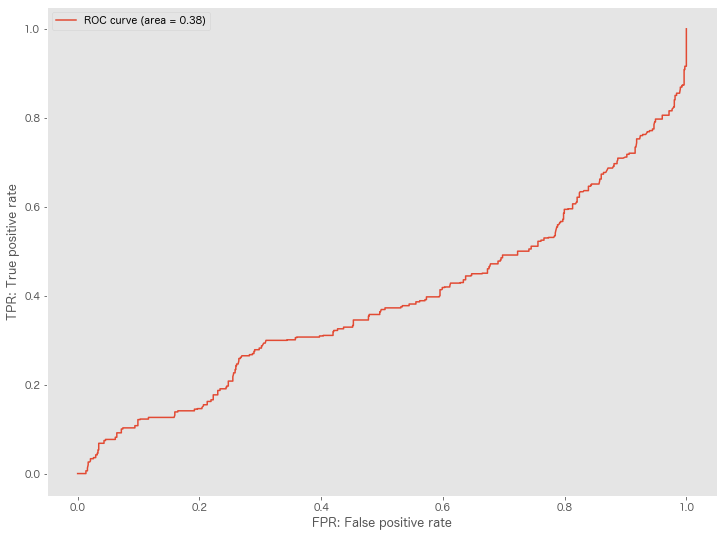

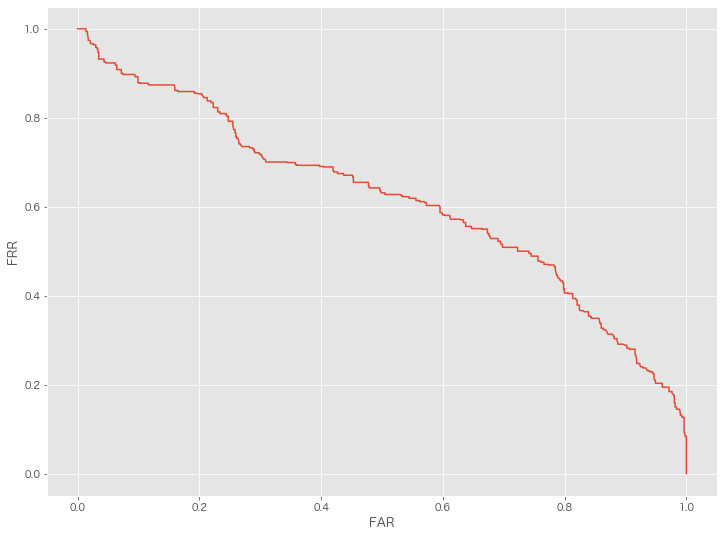

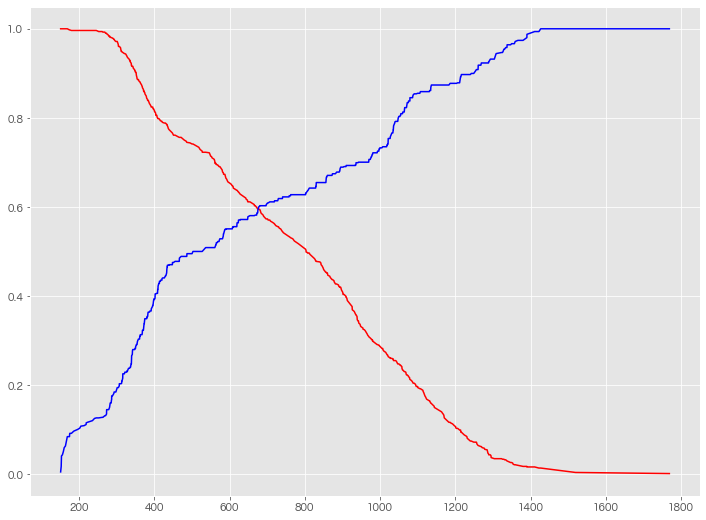

In [13]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_2 = []
score_I_2 = []

diff_day_1 = 30
diff_day_2 = 30

data = df


for h in range(len(users)):
    user = users[h]
    for i in range(0, 101):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=diff_day_1)
        imposters = users.copy()
        imposters = imposters[~(imposters == user)]
        imposter = np.random.choice(imposters)

        t_Q_2 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )

        q = t_Q_2.battery.quantile(0.9)
        t_Q_2 = t_Q_2.query("battery < @q")

        t_T_2 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                & (data["date"] < (first_date[0]))
            ]["battery"].copy()
        )

        q = t_T_2.battery.quantile(0.9)
        t_T_2 = t_T_2.query("battery < @q")

        i_Q_2 = pd.DataFrame(
            data.loc[
                (data["User"] == imposter)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )

        q = i_Q_2.battery.quantile(0.9)
        i_Q_2 = i_Q_2.query("battery < @q")

        a, b, ddtw_1_2 = DDTW(t_T_2, t_Q_2)
        score_G_2.append(ddtw_1_2)

        a, b, ddtw_2_2 = DDTW(t_T_2, i_Q_2)
        score_I_2.append(ddtw_2_2)

grand_truth = np.concatenate((np.ones(len(score_G_2)), np.zeros(len(score_I_2))))
score = np.concatenate((score_G_2, score_I_2))
far, tpr, threshold = metrics.roc_curve(grand_truth, score)
auc = metrics.auc(far, tpr)
frr = 1.0 - tpr
eer = far[np.where((far - frr) < 0)[0][-1]]
print(eer)


plt.plot(far, tpr, label="ROC curve (area = %.2f)" % auc)
plt.legend()
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.show()

plt.plot(far, frr)
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.show()

far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])
plt.plot(far_kai, color="r")
plt.plot(frr_kai, color="b")
plt.show()
# print((first_date[0] + dt.timedelta(seconds=1)), last_date[0])
# print(first_date[0] - dt.timedelta(days=diff_day_2), first_date[0])
# print(len(t_Q), len(t_T))
# print(ddtw)

0.5693069306930693


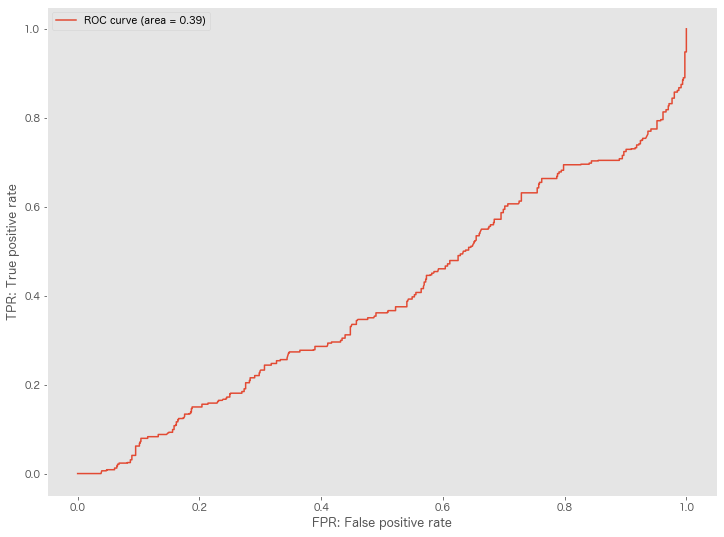

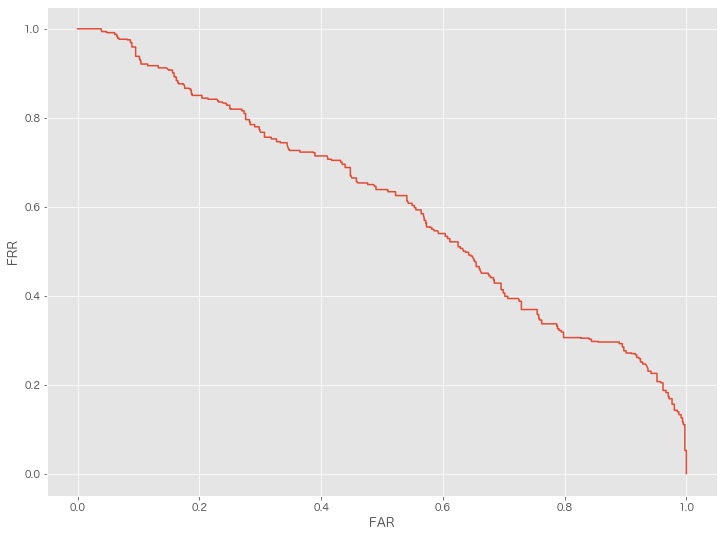

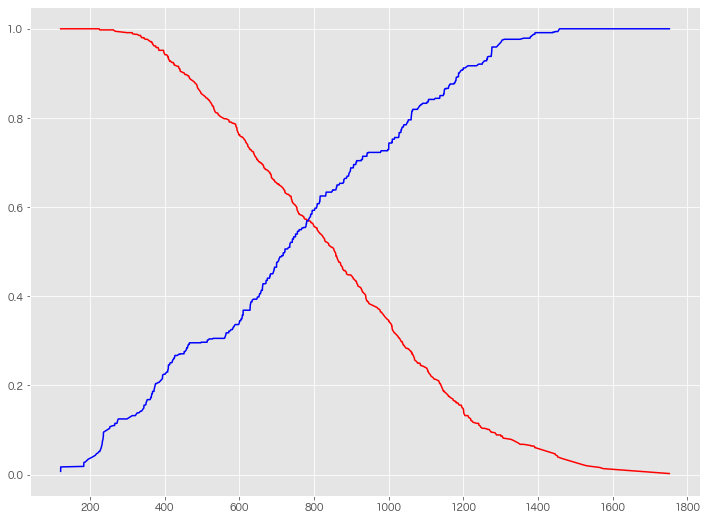

In [28]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_3 = []
score_I_3 = []

diff_day_1 = 30
diff_day_2 = 30

data = df
clf = LocalOutlierFactor(n_neighbors=3)

for h in range(len(users)):
    user = users[h]
    for i in range(0, 101):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=diff_day_1)
        imposters = users.copy()
        imposters = imposters[~(imposters == user)]
        imposter = np.random.choice(imposters)

        clf = LocalOutlierFactor(n_neighbors=3)

        t_Q_3 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )

        t_Q_3 = np.array(t_Q_3)
        t_Q_3 = t_Q_3.reshape(len(t_Q_3), 1)
        pred = clf.fit_predict(t_Q_3)
        t_Q_3 = t_Q_3[np.where(pred > 0)]
        t_Q_3 = pd.DataFrame(t_Q_3, columns=["battery"])

        t_T_3 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > (first_date[0] - dt.timedelta(days=diff_day_2)))
                & (data["date"] < (first_date[0]))
            ]["battery"].copy()
        )
        t_T_3 = np.array(t_T_3)
        t_T_3 = t_T_3.reshape(len(t_T_3), 1)
        pred = clf.fit_predict(t_T_3)
        t_T_3 = t_T_3[np.where(pred > 0)]
        t_T_3 = pd.DataFrame(t_T_3, columns=["battery"])

        i_Q_3 = pd.DataFrame(
            data.loc[
                (data["User"] == imposter)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )
        i_Q_3 = np.array(i_Q_3)
        i_Q_3 = i_Q_3.reshape(len(i_Q_3), 1)
        pred = clf.fit_predict(i_Q_3)
        i_Q_3 = i_Q_3[np.where(pred > 0)]
        i_Q_3 = pd.DataFrame(i_Q_3, columns=["battery"])

        a, b, ddtw_1_3 = DDTW(t_T_3, t_Q_3)
        score_G_3.append(ddtw_1_3)

        a, b, ddtw_2_3 = DDTW(t_T_3, i_Q_3)
        score_I_3.append(ddtw_2_3)

grand_truth = np.concatenate((np.ones(len(score_G_3)), np.zeros(len(score_I_3))))
score = np.concatenate((score_G_3, score_I_3))
far, tpr, threshold = metrics.roc_curve(grand_truth, score)
auc = metrics.auc(far, tpr)
frr = 1.0 - tpr
eer = far[np.where((far - frr) < 0)[0][-1]]
print(eer)


plt.plot(far, tpr, label="ROC curve (area = %.2f)" % auc)
plt.legend()
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.show()

plt.plot(far, frr)
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.show()

far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])
plt.plot(far_kai, color="r")
plt.plot(frr_kai, color="b")
plt.show()
# print((first_date[0] + dt.timedelta(seconds=1)), last_date[0])
# print(first_date[0] - dt.timedelta(days=diff_day_2), first_date[0])
# print(len(t_Q), len(t_T))
# print(ddtw)
# EER:0.5618811881188119

0.5841584158415841


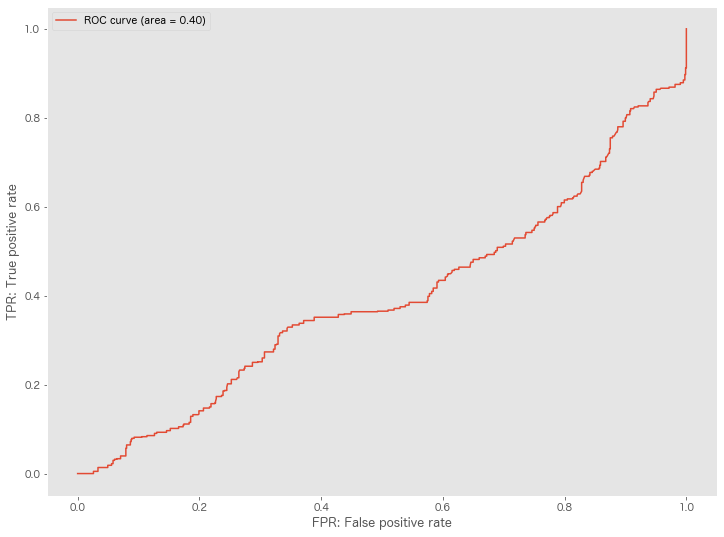

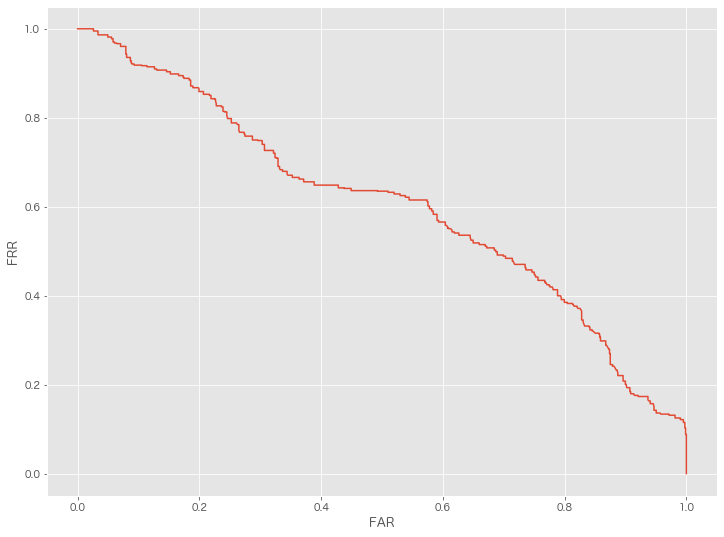

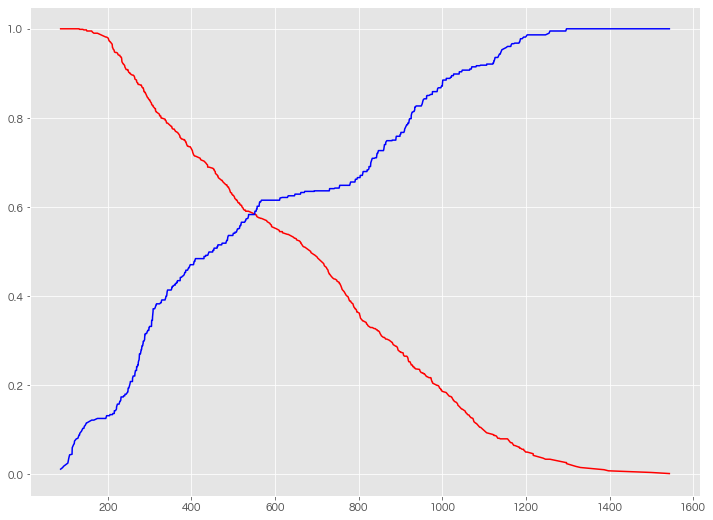

In [29]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G_4 = []
score_I_4 = []

diff_day_1 = 30
diff_day_4 = 30

data = df
clf = LocalOutlierFactor(n_neighbors=3)

for h in range(len(users)):
    user = users[h]
    for i in range(0, 101):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=diff_day_1)
        imposters = users.copy()
        imposters = imposters[~(imposters == user)]
        imposter = np.random.choice(imposters)

        clf = LocalOutlierFactor(n_neighbors=3)

        t_Q_4 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )
        q = t_Q_4.battery.quantile(0.9)
        t_Q_4 = t_Q_4.query("battery < @q")

        t_Q_4 = np.array(t_Q_4)
        t_Q_4 = t_Q_4.reshape(len(t_Q_4), 1)
        pred = clf.fit_predict(t_Q_4)
        t_Q_4 = t_Q_4[np.where(pred > 0)]
        t_Q_4 = pd.DataFrame(t_Q_4, columns=["battery"])

        t_T_4 = pd.DataFrame(
            data.loc[
                (data["User"] == user)
                & (data["state"] == "ON")
                & (data["date"] > (first_date[0] - dt.timedelta(days=diff_day_4)))
                & (data["date"] < (first_date[0]))
            ]["battery"].copy()
        )
        q = t_T_4.battery.quantile(0.9)
        t_T_4 = t_T_4.query("battery < @q")

        t_T_4 = np.array(t_T_4)
        t_T_4 = t_T_4.reshape(len(t_T_4), 1)
        pred = clf.fit_predict(t_T_4)
        t_T_4 = t_T_4[np.where(pred > 0)]
        t_T_4 = pd.DataFrame(t_T_4, columns=["battery"])

        i_Q_4 = pd.DataFrame(
            data.loc[
                (data["User"] == imposter)
                & (data["state"] == "ON")
                & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                & (data["date"] < last_date[0])
            ]["battery"].copy()
        )
        q = i_Q_4.battery.quantile(0.9)
        i_Q_4 = i_Q_4.query("battery < @q")

        i_Q_4 = np.array(i_Q_4)
        i_Q_4 = i_Q_4.reshape(len(i_Q_4), 1)
        pred = clf.fit_predict(i_Q_4)
        i_Q_4 = i_Q_4[np.where(pred > 0)]
        i_Q_4 = pd.DataFrame(i_Q_4, columns=["battery"])

        a, b, ddtw_1_4 = DDTW(t_T_4, t_Q_4)
        score_G_4.append(ddtw_1_4)

        a, b, ddtw_2_4 = DDTW(t_T_4, i_Q_4)
        score_I_4.append(ddtw_2_4)

grand_truth = np.concatenate((np.ones(len(score_G_4)), np.zeros(len(score_I_4))))
score = np.concatenate((score_G_4, score_I_4))
far, tpr, threshold = metrics.roc_curve(grand_truth, score)
auc = metrics.auc(far, tpr)
frr = 1.0 - tpr
eer = far[np.where((far - frr) < 0)[0][-1]]
print(eer)


plt.plot(far, tpr, label="ROC curve (area = %.2f)" % auc)
plt.legend()
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.show()

plt.plot(far, frr)
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.show()

far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])
plt.plot(far_kai, color="r")
plt.plot(frr_kai, color="b")
plt.show()
# print((first_date[0] + dt.timedelta(seconds=1)), last_date[0])
# print(first_date[0] - dt.timedelta(days=diff_day_4), first_date[0])
# print(len(t_Q), len(t_T))
# print(ddtw)
# EER:0.5618811881188119